In [170]:
#Load required libraries

'''Torch Libraries required to train Neural Network'''

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

'''Library required to train neural network using federated learning. Syft overloads PyTorch'''

import syft as sy

<h2>Setting of Learning Task</h2>

In [171]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 2
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 10
        self.save_model = False
        
args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

<h1>Load and Distribute Dataset</h1>

In [172]:
def Load_Data():
    
    '''Load CIFAR dataset from torch vision module and split to training/test set'''
    
    transform = transforms.Compose(
                [transforms.ToTensor(),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    #Training Dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                              shuffle=True, num_workers=0)
    
    #Test Dataset
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)
    
    return (trainloader,testloader)    

In [190]:
def FederatedDataset(nodes,data):
    
    '''Distribute the dataset to compute nodes'''
    
    train_distributed_dataset = []

    n_batch = 937

    trainloader,testloader=Load_Data()

    for batch_idx, (data,target) in enumerate(trainloader):
        if batch_idx % 20 == 0:
            print(round(100*batch_idx/n_batch), '%')
        data = data.send(compute_nodes[batch_idx % len(compute_nodes)])
        target = target.send(compute_nodes[batch_idx % len(compute_nodes)])
        train_distributed_dataset.append((data, target))
        '''if batch_idx > 13000: #TODO rm this limit which is just for dev to have less data to load and train
             break'''
        
    print('Done !')
    
    return (train_distributed_dataset)
    

<h3>Initialize Workers</h3>

In [191]:
#Hook Torch instance with Syft Hook
hook = sy.TorchHook(torch)

#Initialize workers
me = hook.local_worker
bob = sy.VirtualWorker(id="bob",hook=hook, is_client_worker=False)
alice = sy.VirtualWorker(id="alice",hook=hook, is_client_worker=False)

#Define compute nodes
compute_nodes = [bob, alice]

#Add worker instances
me.add_workers([bob, alice])
bob.add_workers([me, alice])
alice.add_workers([me, bob])


<h3>Distribute Data to Workers</h3>

In [192]:
#TODO leverage FederatedDataset and FederatedDataloader

#Load required dataset
trainloader,testloader=Load_Data()

#Distribute dataset among workers
train_distributed_dataset = FederatedDataset(compute_nodes,trainloader)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0 %
2 %
4 %
6 %
9 %
11 %
13 %
15 %
17 %
19 %
21 %
23 %
26 %
28 %
30 %
32 %
34 %
36 %
38 %
41 %
43 %
45 %
47 %
49 %
51 %
53 %
55 %
58 %
60 %
62 %
64 %
66 %
68 %
70 %
73 %
75 %
77 %
79 %
81 %
83 %
85 %
88 %
90 %
92 %
94 %
96 %
98 %
100 %
102 %
105 %
107 %
109 %
111 %
113 %
115 %
117 %
120 %
122 %
124 %
126 %
128 %
130 %
132 %
134 %
137 %
139 %
141 %
143 %
145 %
147 %
149 %
152 %
154 %
156 %
158 %
160 %
162 %
164 %
166 %
169 %
171 %
173 %
175 %
177 %
179 %
181 %
184 %
186 %
188 %
190 %
192 %
194 %
196 %
199 %
201 %
203 %
205 %
207 %
209 %
211 %
213 %
216 %
218 %
220 %
222 %
224 %
226 %
228 %
231 %
233 %
235 %
237 %
239 %
241 %
243 %
245 %
248 %
250 %
252 %
254 %
256 %
258 %
260 %
263 %
265 %
267 %
269 %
271 %
273 %
275 %
277 %
280 %
282 %
284 %
286 %
288 %
290 %
292 %
295 %
297 %
299 %
301 %
303 %
305 %
307 %
309 %
312 %
314 %
316 %
318 %


<h1>Visualize Dataset</h1>

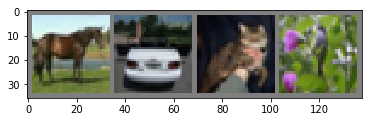

horse   car   cat  bird


In [193]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<h1>Define Neural Network Model</h1>

In [194]:
class Net(nn.Module):
    
    '''Neural Network Model'''
    
    def __init__(self):
        
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x        
    

<h1>Train Network</h1>

In [204]:

def train(model,loader,optimizer,epoch):

   model.train()
   for epoch in range(2):  # loop over the dataset multiple times

      for batch_idx, (data, target) in enumerate(train_distributed_dataset): # <-- now it is a distributed dataset
           model.send(data.location) # <-- NEW: send the model to the right location
           #TODO data, target = data.to(device), target.to(device)
           output = model(data)
           loss = F.nll_loss(output, target)
           loss.backward()
           optimizer.step()
           model.get() # <-- NEW: get the model back
           if batch_idx % 1000 == 0:
               loss = loss.get() # <-- NEW: get the loss back
               print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                 epoch, batch_idx * args.batch_size, len(loader) * args.batch_size, #batch_idx * len(data), len(train_loader.dataset),
                 100. * batch_idx / len(loader), loss.item()))
                
            
    

In [210]:
def test(model,device,test_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            #TODO should be using with kwargs: output.argmax(dim=1, keepdim=True)
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [211]:

model=Net()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
optimizer.zero_grad() 


In [212]:
for epoch in range(1, args.epochs + 1):
    train(model,trainloader, optimizer, epoch)
    test(model, device, testloader)

if (args.save_model):
    torch.save(model.state_dict(), "federated_cifar10.pt")

Train Epoch: 0 [0/800000 (0%)]	Loss: 0.035673


TypeError: add_() takes 1 positional argument but 2 were given